In [1]:
import sys

if not r'C:\Users\Michelle\Documents\GitHub\TRANSPIRE' in sys.path:
    sys.path.append(r'C:\Users\Michelle\Documents\GitHub\TRANSPIRE')
    
if not r'C:\Users\mak4\Documents\GitHub\TRANSPIRE' in sys.path:
    sys.path.append(r'C:\Users\mak4\Documents\GitHub\TRANSPIRE')

%load_ext autoreload
%autoreload 2

import TRANSPIRE

import pandas as pd
import numpy as np


## Post-processing of TRANSPIRE results


#### 1. Load data, define comparisons, and generate synthetic translocations

In [12]:
f = r'Z:\2 Programming\1 Translocation program\JASMS_revisions\CNB_TMT_analysis\Betsinger2020.csv'

df = TRANSPIRE.data.import_data.load_data(f).groupby('localization', group_keys=False).apply(lambda x: x.sample(10))

organelle_mappings = {
    'Lysosome': 'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)', 
    'Plasma membrane':'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)', 
    'ER': 'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)', 
    'Golgi': 'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)', 
    'Peroxisome': 'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)', 
    'Mitochondria': 'Mitochondria', 
    'Nucleus': 'Nucleus',
    'Dense cytosol': 'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)',
}

df = TRANSPIRE.utils.group_organelles(df, organelle_mappings)
comparisons = list(zip(df.columns.levels[1][df.columns.levels[1].str.contains('Mock')], df.columns.levels[1][~df.columns.levels[1].str.contains('Mock')]))

mapping, mapping_r = TRANSPIRE.utils.get_mapping(df)

#### 2. Load TRANSPIRE predictions

In [10]:
predictions = TRANSPIRE.import_data.load_predictions()


array(['Mitochondria to Mitochondria', 'Mitochondria to Nucleus',
       'Mitochondria to Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)',
       'Nucleus to Mitochondria', 'Nucleus to Nucleus',
       'Nucleus to Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)',
       'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome) to Mitochondria',
       'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome) to Nucleus',
       'Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome) to Organellear (Plasma membrane, Dense cytosol, ER, Golgi, Peroxisome)'],
      dtype='<U138')

In [3]:
f_train = 0.5 # fraction dedicated to training data
f_validate = 0.25 # fraction dedicated to validation (i.e. used to assess hyperparameter performance)
f_test = 0.25 # fraction dedicated to assessing final predictive performance

X_train_validate, X_train_df, X_validate_df, X_test_df = TRANSPIRE.utils.train_test_validate_split(synth_translocs, 
                                                                                                   ['condition_A', 'condition_B', 'label'], 
                                                                                                   f_train, 
                                                                                                   f_validate, 
                                                                                                   f_test)

Splitting data into training, validation, and testing folds (this may take a while) . . . done


In [6]:
weights = X_train_validate.groupby(['condition_A', 'condition_B']).apply(lambda x: x.shape[0]/(x.groupby('label').size()))
weights = weights.apply(lambda x: x/weights.sum(axis=1))

#### 3. Define model parameters and architecture

In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow

# where to save the models (make sure that this path exists)
base_dir = r'C:\Users\mak4\Desktop\pipeline_devel'

# n_induce and kern_func found via hyperparameter optimization (or not...)
n_induce = 20
kern_func = gpflow.kernels.SquaredExponential

# max number of calls to the optimizer for each model that is built
maxiter = 20

# learning rate for the Adam optimizer (too low of a learning rate will prevent the model from reaching an optimal solution; too high and the fitting may diverge)
learning_rate = 0.05

# whether to implement interactive plotting to track fit progress
plot_fit = True

#### 6. Train and save models for n-folds of each combination of conditions defined in comparisons

<IPython.core.display.Javascript object>


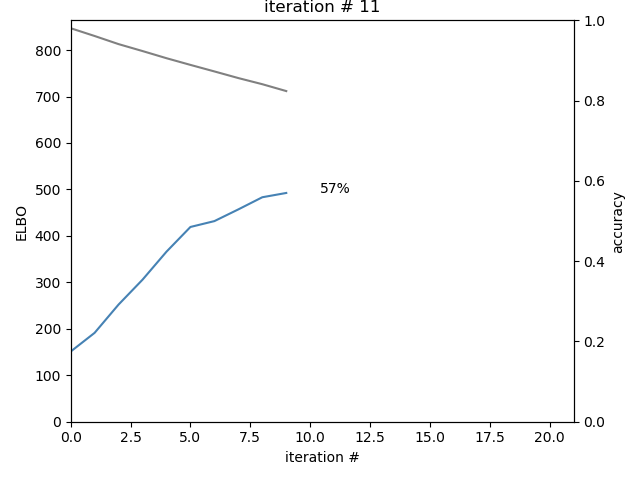

KeyboardInterrupt: 

In [21]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow
import os

import TRANSPIRE.training

%matplotlib notebook

gpflow.reset_default_graph_and_session()

if plot_fit == True:
    
    import TRANSPIRE.visualization.training_monitor
    import matplotlib.pyplot as plt
    
    # for tracking fitting progress
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_2 = ax.twinx()

# build and fit a model for each set of conditions for each fold of training data
for (condA, condB), X_train in X_train_validate.groupby(['condition_A', 'condition_B']):
    
    X = X_train.values
    y = X_train.index.get_level_values('label').map(mapping).values.reshape(-1, 1) # encode labels
    w = weights.loc[(condA, condB), :][X_train.index.get_level_values('label')].values.reshape(-1, 1)
    Z = TRANSPIRE.training.compute_inducing(X, n_induce)
    
    # define kernel function (with noise kernel added)
    kernel = kern_func(X.shape[1], ARD=True) + gpflow.kernels.White(X.shape[1], variance=1)

    model_params = {
        'kernel': kernel,
        'weights': w,
        'Z': Z,
    }
    
    # build the model
    m = TRANSPIRE.training.build_model(X, y, **model_params)

    # allow the optimizer to train both inducing points and the noise level (optional...one or more may be set to false--up to user-discresssion)
    m.feature.Z.trainable = True
    m.kern.kernels[1].trainable = True

    session = gpflow.get_default_session()

    if plot_fit == True:
        
        ax.clear()
        ax_2.clear()
        window = max(1, int(maxiter/50))
        tracker = TRANSPIRE.visualization.training_monitor.ProgressTracker(m, X, y)
        plotter = TRANSPIRE.visualization.training_monitor.ProgressPlotter(fig, ax, ax_2, maxiter, m.compute_log_likelihood(X)*-1, window)
        callback = TRANSPIRE.visualization.training_monitor.CustomCallback(tracker, plotter)

        opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
        opt.minimize(m, maxiter=maxiter, step_callback=callback.update)

    else:

        opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
        opt.minimize(m, maxiter=maxiter)

    # save the optimized model 
    m.anchor(session)
    gpflow.saver.Saver().save(os.path.join(base_dir, 'ELBO={:.0f}_{}_{}'.format(m.compute_log_likelihood(X), condA, condB)), m)

    # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
    gpflow.reset_default_graph_and_session()     

#### 7. Evaluate each model on the testing data

In [24]:
import os

eval_limit = 10000 # max number of samples to evaluate at once (conserve RAM usage)
n_chunks = int(np.ceil(X_test_df.shape[0]/eval_limit))

result = {}

gpflow.reset_default_graph_and_session()

for k, _ in training_data.groupby(['condition_A', 'condition_B', 'fold']):
    
    condA, condB, fold = k
    
    m_path = [path for path in os.listdir(base_dir) if (all([str(s) in path for s in k])&(path.endswith('_{}'.format(k[-1]))))][0]
    
    m = gpflow.saver.Saver().load(os.path.join(base_dir, m_path))
    
    X = X_test_df[(X_test_df.index.get_level_values('condition_A')==condA) &(X_test_df.index.get_level_values('condition_B')==condB)]
    
    means = []
    vars_ = []
    
    print(m_path, end=' ')
    
    for i, arr in enumerate(np.array_split(X, n_chunks)):
        mns, vrs_ = m.predict_y(arr.values)
    
        mns = pd.DataFrame(mns, index=arr.index).reset_index(['condition_A', 'condition_B'], drop=True)
        vrs_ = pd.DataFrame(vrs_, index = arr.index).reset_index(['condition_A', 'condition_B'], drop=True)
        
        means.append(mns)
        vars_.append(vrs_)
        
        print(i, end=' ')
        
    means = pd.concat(means)
    vars_ = pd.concat(vars_)
    
    result[(condA, condB, fold)] = pd.concat([means, vars_], axis=1, keys = ['score','uncertainty'])
    
    gpflow.reset_default_graph_and_session()
    
    print()
    
result = pd.concat(result, names = ['condition_A', 'condition_B', 'fold'])

ELBO=-76315_Mock 12 R1_Infected 12 R1_1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
ELBO=-76151_Mock 12 R1_Infected 12 R1_2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
ELBO=-75736_Mock 24 R1_Infected 24 R1_1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
ELBO=-75521_Mock 24 R1_Infected 24 R1_2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
ELBO=-75356_Mock 6 R1_Infected 6 R1_1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
ELBO=-75103_Mock 6 R1_Infected 6 R1_2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 


#### 9. Visualize the results and evaluate predictive performance


In [43]:
import TRANSPIRE.training

performance = result.score.groupby(['condition_A', 'condition_B', 'fold']).apply(lambda x: TRANSPIRE.training.performance.eval_report(x, mapping, mapping_r)).apply(lambda x: pd.concat(x, names = ['type of metric', 'metric']))

In [45]:
performance['singular metrics']

metric                               loss  F1 score (micro)  F1 score (macro)  \
condition_A condition_B    fold                                                 
Mock 12 R1  Infected 12 R1 1     2.445716          0.402004          0.237770   
                           2     2.447271          0.404554          0.239761   
Mock 24 R1  Infected 24 R1 1     2.436439          0.402730          0.240281   
                           2     2.437117          0.402146          0.242888   
Mock 6 R1   Infected 6 R1  1     2.401460          0.426260          0.252250   
                           2     2.392189          0.426199          0.252603   

metric                           F1 score (weighted)  loss (binary)  \
condition_A condition_B    fold                                       
Mock 12 R1  Infected 12 R1 1                0.399306       0.430134   
                           2                0.402223       0.430624   
Mock 24 R1  Infected 24 R1 1                0.400188       0.429061   
                           2                0.400123       0.429212   
Mock 6 R1   Infected 6 R1  1                0.424310       0.428722   
                           2                0.423275       0.425043   

metric                           F1 score (weighted, binary)  
condition_A condition_B    fold                               
Mock 12 R1  Infected 12 R1 1                         0.71207  
                           2                         0.71207  
Mock 24 R1  Infected 24 R1 1                         0.71207  
                           2                         0.71207  
Mock 6 R1   Infected 6 R1  1                         0.71207  
                           2                         0.71207

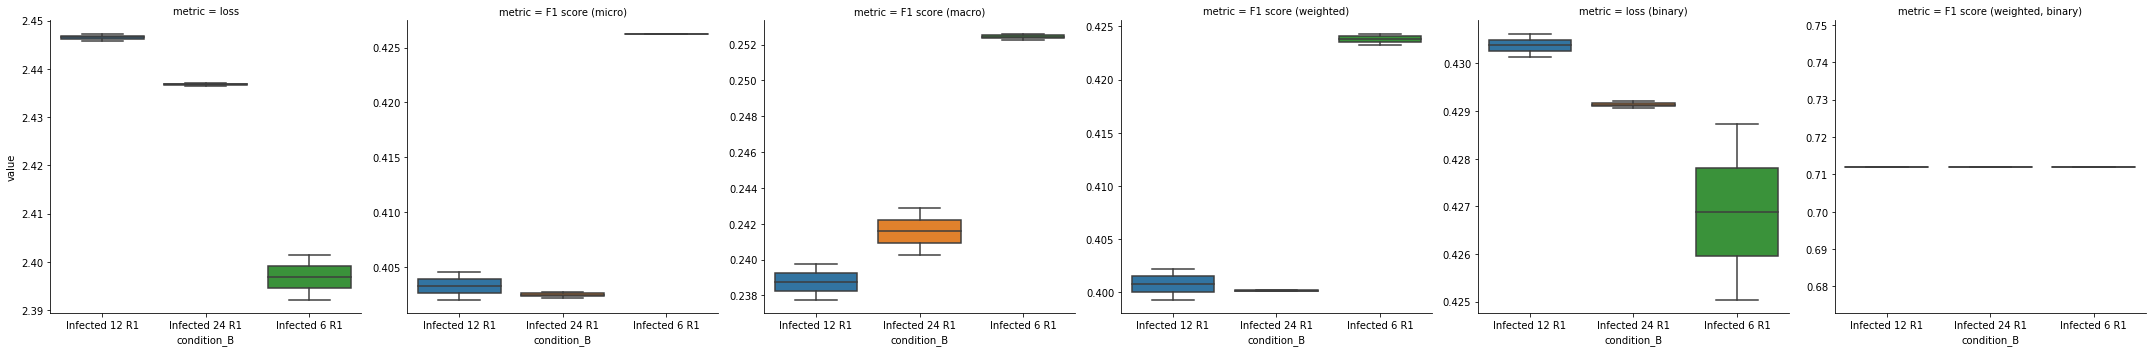

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

temp = performance['singular metrics'].dropna()
sns.catplot(data=temp.reset_index().melt(temp.index.names), col='metric', sharey=False, x='condition_B', y='value', kind='box')

plt.show()

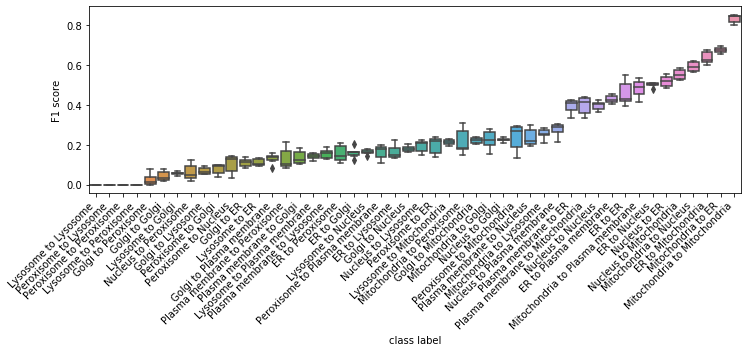

In [69]:
temp = performance['F1 score (per class)']

fig, ax = plt.subplots(figsize = (10.5, 5))

order = temp.mean().sort_values().index.values.tolist()

sns.boxplot(data=temp.reset_index().melt(temp.index.names), hue='metric', x='metric', y='value', 
            dodge=False, order=order, hue_order=order)

ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('class label')
ax.set_ylabel('F1 score')

fig.tight_layout()
plt.show()

#### 10. Compute FPR cutoff(s) for translocation scores

In [70]:
binary = TRANSPIRE.utils.map_binary(result.score, mapping_r)
fprs = binary.groupby(['condition_A', 'condition_B', 'fold']).apply(TRANSPIRE.training.performance.compute_fpr)

cutoff_fpr = 0.05 # 5 FPR cutoff%
cutoffs = fprs[fprs<0.01].idxmax(axis=1).groupby(['condition_A', 'condition_B']).mean()

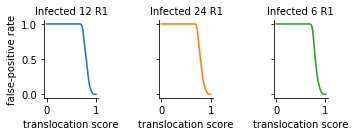

In [63]:
g=sns.FacetGrid(data=fprs.reset_index().melt(fprs.index.names), col='condition_B', 
                height=2, aspect = 0.85,
                hue='condition_B',

               )
g.map(sns.lineplot, 'variable', 'value', ci='sd')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

for i, ax in enumerate(g.axes.flatten()):
    ax.set_xlabel('translocation score')

    if i==0:
        ax.set_ylabel('false-positive rate')

ax.get_figure().tight_layout()

#ax.get_figure().savefig('fpr_cutoffs.svg', dpi=300)
plt.show()

#### 11. Evaluate models on the actual data (finally... )

In [75]:
# concatenate actual protein profiles between conditions
actual_profiles = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons, synthetic=False)

predicted_scores = {}

for k, _ in training_data.groupby(['condition_A', 'condition_B', 'fold']):
    
    condA, condB, fold = k
    X = actual_profiles[(actual_profiles.index.get_level_values('condition_A')==condA)&(actual_profiles.index.get_level_values('condition_B')==condB)].reset_index(['condition_A', 'condition_B'], drop=True)

    m_path = [path for path in os.listdir(base_dir) if (all([str(s) in path for s in k])&(path.endswith('_{}'.format(k[-1]))))][0]
    
    m = gpflow.saver.Saver().load(os.path.join(base_dir, m_path))
    
    means, vars_ = m.predict_y(X.values)
    means = pd.DataFrame(means, index=X.index)
    vars_ = pd.DataFrame(vars_, index = X.index)
    
    predicted_scores[k] = pd.concat([means, vars_], axis=1, keys = ['score', 'uncertainty'])
    
    gpflow.reset_default_graph_and_session()
    
    print(k)
    
predicted_scores = pd.concat(predicted_scores, names = ['condition_A', 'condition_B', 'fold'])


('Mock 12 R1', 'Infected 12 R1', 1)
('Mock 12 R1', 'Infected 12 R1', 2)
('Mock 24 R1', 'Infected 24 R1', 1)
('Mock 24 R1', 'Infected 24 R1', 2)
('Mock 6 R1', 'Infected 6 R1', 1)
('Mock 6 R1', 'Infected 6 R1', 2)


In [80]:
binary_predictions = TRANSPIRE.utils.map_binary(predicted_scores.score, mapping_r)

In [95]:
p = binary_predictions[binary_predictions['translocation']>=cutoffs[list(zip(binary_predictions.index.get_level_values('condition_A').values, binary_predictions.index.get_level_values('condition_B').values))].values]

In [96]:
p

,,,,,,,,,no translocation,translocation
condition_A,condition_B,fold,accession_A,localization_A,gene name_A,accession_B,localization_B,gene name_B,,
